**TODO** (if time allows):
- add different types of ray sampling

**IDEA**:
- A WAY TO CHECK IF PLUCKER EMBED IS CORRECT CAN BE BY COMPUTING THE CHANGES IN PLUCKER EMBEDDINGS AND COMPUTE THE K,P VALUES BACK AND SEE IF THEY CORRESPOND TO THAT OPERATION. This is for the augmentation part.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from src.data import parse_directory, save_data

is_vm = True
path_test = "../RealEstate10K/test" if is_vm else "../RealEstate10K/RealEstate10K/test"
path_train = "../RealEstate10K/train" if is_vm else "../RealEstate10K/RealEstate10K/train"

# Data Extraction

Here we extract the data with the camera model matrices and Plücker embeddings for training and testing from the RealEstate10k dataset. We take a smaller subset of the original dataset.

In [ ]:
test_data_small = parse_directory(path_test, subset_size=0.2)
save_data(test_data_small, "data/test_small.pkl")
# not pushed to git repo for memory reasons

Processing RealEstate10K files:   0%|          | 0/1542 [00:00<?, ?file/s]

Processing RealEstate10K files: 100%|██████████| 1542/1542 [00:09<00:00, 156.93file/s]


Data successfully saved to data/test_small.pkl


In [ ]:
train_data_small = parse_directory(path_train, subset_size=0.2)
save_data(train_data_small, "data/train_small.pkl")
# not pushed to git repo for memory reasons

Processing RealEstate10K files:   0%|          | 0/14311 [00:00<?, ?file/s]

Processing RealEstate10K files: 100%|██████████| 14311/14311 [00:58<00:00, 244.88file/s]


Data successfully saved to data/train_small.pkl


# Example

Let's have a look at an example to understand the type of data we have.

In [4]:
# Check the overall structure of the parsed data
print(f"Type of parsed data: {type(test_data_small)}")
print(f"Number of video files processed: {len(test_data_small)}\n")

# Select a specific file from the dataset
file_idx = 0
file_test = test_data_small[file_idx]

print(f"Type of an individual file's data: {type(file_test)}")
print(f"Keys available in the selected file data: {list(file_test.keys())}\n")

# Video metadata
print(f"Video URL: {file_test['url']}\n")

# Timestamps (frame time in microseconds)
print(f"Shape of timestamps array: {file_test['timestamps'].shape} (Number of frames)")
print(f"First 5 timestamps (in microseconds since video start): {file_test['timestamps'][:5]}\n")

# Camera intrinsics (same for all frames)
print(f"Intrinsic matrix shape: {file_test['K'].shape}")
print(f"Intrinsic matrix K:\n{file_test['K']}\n")
f_x = file_test['K'][0, 0]
f_y = file_test['K'][1, 1]
c_x = file_test['K'][0, 2]
c_y = file_test['K'][1, 2]

print(f"Focal length along X-axis (f_x): {f_x}")
print(f"Focal length along Y-axis (f_y): {f_y}")
print(f"Principal point X (c_x): {c_x}")
print(f"Principal point Y (c_y): {c_y}\n")

Type of parsed data: <class 'list'>
Number of video files processed: 1542

Type of an individual file's data: <class 'dict'>
Keys available in the selected file data: ['url', 'K', 'timestamps', 'extrinsics', 'plucker']

Video URL: https://www.youtube.com/watch?v=-lF1OltRIOw

Shape of timestamps array: torch.Size([279]) (Number of frames)
First 5 timestamps (in microseconds since video start): tensor([1.3310e+08, 1.3313e+08, 1.3317e+08, 1.3320e+08, 1.3323e+08])

Intrinsic matrix shape: torch.Size([3, 3])
Intrinsic matrix K:
tensor([[0.5046, 0.0000, 0.5000],
        [0.0000, 0.8971, 0.5000],
        [0.0000, 0.0000, 1.0000]])

Focal length along X-axis (f_x): 0.5046110153198242
Focal length along Y-axis (f_y): 0.8970862627029419
Principal point X (c_x): 0.5
Principal point Y (c_y): 0.5



In [5]:
# Camera extrinsics (pose per frame)
print(f"Extrinsic matrix shape: {file_test['extrinsics'].shape} (num_frames, 3, 4)")
frame_idx = 0  # Choose the first frame
P = file_test["extrinsics"][frame_idx]

print(f"Extrinsic matrix for frame {frame_idx}:\n{P}\n")
print(f"Rotation matrix R for frame {frame_idx}:\n{P[:, :3]}")
print(f"Translation vector t for frame {frame_idx}:\n{P[:, 3]}\n")

Extrinsic matrix shape: torch.Size([279, 3, 4]) (num_frames, 3, 4)
Extrinsic matrix for frame 0:
tensor([[ 0.9899,  0.0092, -0.1416, -0.3894],
        [-0.0095,  1.0000, -0.0012, -0.0143],
        [ 0.1416,  0.0026,  0.9899, -0.3098]])

Rotation matrix R for frame 0:
tensor([[ 0.9899,  0.0092, -0.1416],
        [-0.0095,  1.0000, -0.0012],
        [ 0.1416,  0.0026,  0.9899]])
Translation vector t for frame 0:
tensor([-0.3894, -0.0143, -0.3098])



In [6]:
# Plücker ray embeddings
print(f"Shape of Plücker embeddings: {file_test['plucker'].shape} (num_frames, 6, num_rays_y, num_rays_x)")
print(f"Shape of Plücker embedding for frame {frame_idx}: {file_test['plucker'][frame_idx].shape} (6, num_rays_y, num_rays_x)\n")

# Selecting a random ray
num_rays_x = 16
num_rays_y = 9
ray_idx_x = np.random.randint(0, num_rays_x)
ray_idx_y = np.random.randint(0, num_rays_y)

print(f"Randomly selected ray index: ({ray_idx_y}, {ray_idx_x})\n")

# Full Plücker coordinate for selected ray
print(f"Plücker embedding for selected ray (direction & moment):\n{file_test['plucker'][frame_idx][:, ray_idx_y, ray_idx_x]}\n")

# Direction component (d) of the Plücker embedding
print(f"Direction vector d for the selected ray:\n{file_test['plucker'][frame_idx][:3, ray_idx_y, ray_idx_x]}\n")

# Moment component (m) of the Plücker embedding
print(f"Moment vector m for the selected ray:\n{file_test['plucker'][frame_idx][3:, ray_idx_y, ray_idx_x]}")

Shape of Plücker embeddings: torch.Size([279, 6, 9, 16]) (num_frames, 6, num_rays_y, num_rays_x)
Shape of Plücker embedding for frame 0: torch.Size([6, 9, 16]) (6, num_rays_y, num_rays_x)

Randomly selected ray index: (3, 6)

Plücker embedding for selected ray (direction & moment):
tensor([-0.0332, -0.4371,  0.8988,  0.1268, -0.3941, -0.1870])

Direction vector d for the selected ray:
tensor([-0.0332, -0.4371,  0.8988])

Moment vector m for the selected ray:
tensor([ 0.1268, -0.3941, -0.1870])


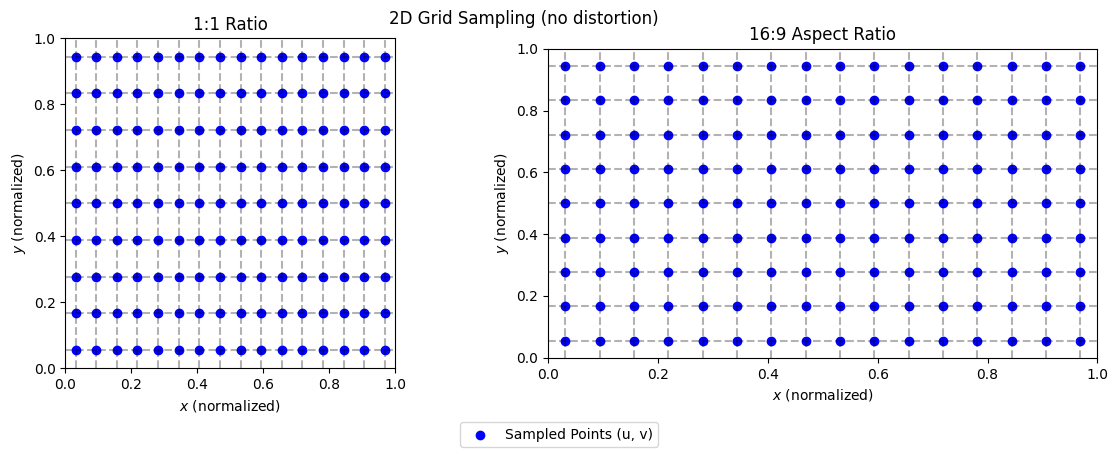

In [7]:
u = np.linspace(0, 1, num_rays_x, endpoint=False) + 0.5 / num_rays_x
v = np.linspace(0, 1, num_rays_y, endpoint=False) + 0.5 / num_rays_y
U, V = np.meshgrid(u, v)
fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))

# 1:1 plot
sc1 = axs[0].scatter(U, V, color='blue', label='Sampled Points (u, v)')
for i in range(num_rays_x):
    axs[0].plot([u[i], u[i]], [0, 1], 'k--', alpha=0.3)  # Vertical lines
for j in range(num_rays_y):
    axs[0].plot([0, 1], [v[j], v[j]], 'k--', alpha=0.3)  # Horizontal lines
axs[0].set_xlabel("$x$ (normalized)")
axs[0].set_ylabel("$y$ (normalized)")
axs[0].set_title("1:1 Ratio")
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 1)
axs[0].set_aspect('equal')  # Normalized square aspect ratio

# 16:9 plot
sc2 = axs[1].scatter(U, V, color='blue', label='Sampled Points (u, v)')
for i in range(num_rays_x):
    axs[1].plot([u[i], u[i]], [0, 1], 'k--', alpha=0.3)  # Vertical lines
for j in range(num_rays_y):
    axs[1].plot([0, 1], [v[j], v[j]], 'k--', alpha=0.3)  # Horizontal lines
axs[1].set_xlabel("$x$ (normalized)")
axs[1].set_ylabel("$y$ (normalized)")
axs[1].set_title("16:9 Aspect Ratio")
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0, 1)
axs[1].set_aspect(9/16)  # True 16:9 aspect ratio

fig.legend(handles=[sc1], labels=['Sampled Points (u, v)'], loc='lower center', ncol=1) # Create a single legend for the figure
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Make space for legend at the bottom
plt.suptitle("2D Grid Sampling (no distortion)")
plt.show()